<img src="logos/Picture1.png" alt="sd" style="width: 50%; height: auto;">

# Supplementary 3
**Variable Selection and Multicollinearity Control**

Articule title

This supplementary section documents the end-to-end workflow used to cluster observations into environmental niches after variable selection (see Supplementary Material 1). We load the filtered dataset (df_important.csv), perform quality control (missing values and invalid elevations), harmonize class balance between Acer saccharum (ES) and Acer rubrum (EO), and standardize numeric predictors. We then reduce dimensionality with PCA up to ~90% explained variance and run a two-stage, resumable K-means search: a fast MiniBatch exploration followed by a refined full K-means around the best candidates. Cluster quality is assessed with Silhouette, Calinski–Harabasz, and Davies–Bouldin indices, and an aggregate rank-based score selects the final k. The final model is trained, metrics saved, labels exported, and clusters are visualized both in PCA space and over a Quebec basemap using geographic coordinates. These results provide the operational partition of the environmental space used in the main text to discuss niche separation and spatial structure.


## Data loading and schema
Load data/df_important.csv enforcing column dtypes to preserve numeric/categorical consistency prior to analysis. Summarize missing values per column to confirm data readiness.


In [1]:
dtype_spec = {
    'latitude': 'float64',
    'longitude': 'float64',
    'geocode': 'object',
    'essence': 'object',
    'RES_CO_REG': 'object'
}

csv_file_path = 'data/df_important.csv'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
db = pd.read_csv(csv_file_path, dtype=dtype_spec)

In [4]:
db

,essence,densite,RES_CO_REG,latitude,forest,longitude,elev,ph,clay,sand,...,bio14,bio15,bio18,bio20,bio23,bio24,bio27,bio30,bio31,bio34
0,EO,85.0,01,48.396359,90,-68.500026,200,4.5500,26.0,37.0,...,36.850,10.911860,272.275,16.149261,88.416040,620.900,31.271425,2.079599,6.006196,668.59720
1,ES,95.0,01,47.996187,94,-68.500146,364,4.2000,11.0,56.0,...,33.825,13.184971,286.625,16.870762,86.148476,633.375,32.459473,-1.594780,7.549124,708.93280
2,ES,75.0,01,47.849696,100,-68.513409,392,4.2000,11.0,56.0,...,33.825,13.184971,286.625,16.870762,86.148476,633.375,32.459473,-1.594780,7.549124,708.93280
3,EO,75.0,01,48.378256,99,-68.635551,150,4.5500,26.0,37.0,...,36.850,10.911860,272.275,16.149261,88.416040,620.900,31.271425,2.079599,6.006196,668.59720
4,EO,75.0,12,47.003192,100,-69.817548,351,3.5167,24.0,45.0,...,33.150,12.382082,285.675,17.312328,82.792880,613.000,31.961720,-1.030399,6.622469,701.65955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658309,ES,85.0,01,48.619350,37,-67.341882,197,4.2000,11.0,56.0,...,35.775,17.265238,296.875,15.893673,96.534830,630.800,31.110240,-2.917435,6.463537,658.10010
1658310,EO,85.0,01,48.621634,83,-67.341360,241,4.2000,11.0,56.0,...,35.775,17.265238,296.875,15.893673,96.534830,630.800,31.110240,-2.917435,6.463537,658.10010
1658311,ES,85.0,01,48.621634,83,-67.341360,241,4.2000,11.0,56.0,...,35.775,17.265238,296.875,15.893673,96.534830,630.800,31.110240,-2.917435,6.463537,658.10010
1658312,EO,85.0,11,47.971029,78,-67.199845,199,4.4400,25.0,31.0,...,30.500,16.370466,290.225,16.206608,92.112206,607.875,31.266043,-1.730635,8.109462,702.31920


In [5]:
num_nan = db.isna().sum()
num_nan

essence       0
densite       0
RES_CO_REG    0
latitude      0
forest        0
longitude     0
elev          0
ph            0
clay          0
sand          0
bio1          0
bio2          0
bio3          0
bio8          0
bio9          0
bio10         0
bio11         0
bio12         0
bio14         0
bio15         0
bio18         0
bio20         0
bio23         0
bio24         0
bio27         0
bio30         0
bio31         0
bio34         0
dtype: int64

Drop non-environmental administrative field RES_CO_REG.

In [6]:
db = db.drop([ 'RES_CO_REG'], axis=1)

# Luego puedes crear db_fil a partir del DataFrame modificado
#db_fil = db[db['essence'] != 'EA']

In [7]:

#print(db_fil.columns)

### Class balance overview
Count and percentage of essence (ES, EO) to diagnose initial imbalance.

In [8]:
category_balance = db['essence'].value_counts()

# Mostrar los resultados
print(category_balance)

essence
EO    1092468
ES     565846
Name: count, dtype: int64


In [9]:
#print(db_fil.columns)

In [10]:
#category_balance = db_fil['essence'].value_counts()

# Mostrar los resultados
#print(category_balance)

In [11]:
category_percentages = db['essence'].value_counts(normalize=True) * 100
print(category_percentages)

essence
EO    65.878235
ES    34.121765
Name: proportion, dtype: float64


In [12]:
negative_elev_points = db[db['elev'] < 0]
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Check for negative values in the 'elev' column
negative_elev_values = db['elev'] < 0

# Count the number of negative values
negative_elev_count = negative_elev_values.sum()

negative_elev_count

np.int64(2281)

Elevation sanity screen... lag, count, and map records with negative elev; remove them and report final sample size.

In [14]:
negative_elev_range = db[db['elev'] < 0]['elev'].agg(['min', 'max'])

# Display the result
print(f"Negative elevation values range from {negative_elev_range['min']} to {negative_elev_range['max']}.")

Negative elevation values range from -32768 to -32768.


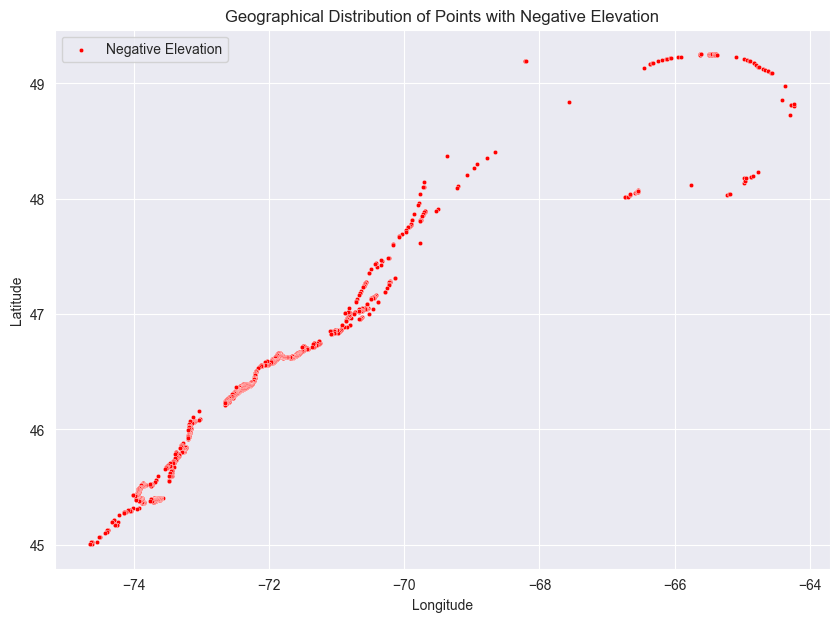

In [15]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=negative_elev_points['longitude'], y=negative_elev_points['latitude'], color='red', s=10, label='Negative Elevation')

# Set plot details
plt.title('Geographical Distribution of Points with Negative Elevation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [16]:
db = db[db['elev'] >= 0].copy()

In [17]:
db_fil = db.copy()

In [18]:
negative_elev_count = (db['elev'] < 0).sum()
print(f'Después de eliminar, quedan {negative_elev_count} valores negativos en la columna "elev".')
print(f'Tamaño final del DataFrame: {db.shape}')

Después de eliminar, quedan 0 valores negativos en la columna "elev".
Tamaño final del DataFrame: (1656033, 27)


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
desired_ratio = 1.5
desired_EO_size = int(db_fil['essence'].value_counts()['ES'] * desired_ratio)

In [21]:
desired_EO_size

847962

In [22]:
EO_sample = db_fil[db_fil['essence'] == 'EO']
EO_sample_balanced = EO_sample.sample(n=desired_EO_size, random_state=42)

In [23]:
ES_sample = db_fil[db_fil['essence'] == 'ES']


In [24]:

# Combinar las muestras submuestreadas de EO con todas las filas de ES
db_balanced = pd.concat([EO_sample_balanced, ES_sample])

In [25]:
del db_fil, db # Si ya no lo necesitas
import gc
gc.collect()  # Forzar la recolección de basura

155

In [26]:
atributos = db_balanced.columns

# Iterar sobre los atributos
for atributo in atributos:
    if db_balanced[atributo].dtype == 'object':
        # Columna cualitativa: Mostrar niveles únicos
        niveles = db_balanced[atributo].unique()
        print(f"Atributo: {atributo} (Cualitativo)")
        print(f"Niveles: {niveles}")
    else:
        # Columna cuantitativa: Mostrar desviación estándar y media
        desviacion_estandar = db_balanced[atributo].std()
        media = db_balanced[atributo].mean()
        print(f"Atributo: {atributo} (Cuantitativo)")
        print(f"Desviación estándar: {desviacion_estandar}")
        print(f"Media: {media}")
    print()

Atributo: essence (Cualitativo)
Niveles: ['EO' 'ES']

Atributo: densite (Cuantitativo)
Desviación estándar: 12.97631163367853
Media: 77.51362443128347

Atributo: latitude (Cuantitativo)
Desviación estándar: 0.8910473788504474
Media: 46.66690688140548

Atributo: forest (Cuantitativo)
Desviación estándar: 11.820235466670285
Media: 95.45740021368881

Atributo: longitude (Cuantitativo)
Desviación estándar: 3.1094910511552736
Media: -73.41723896875368

Atributo: elev (Cuantitativo)
Desviación estándar: 124.49238564899917
Media: 314.44610725480624

Atributo: ph (Cuantitativo)
Desviación estándar: 0.7144903599691271
Media: 4.809430036923902

Atributo: clay (Cuantitativo)
Desviación estándar: 34.97479719327399
Media: 36.53881282415957

Atributo: sand (Cuantitativo)
Desviación estándar: 24.60850636081326
Media: 62.20060497994014

Atributo: bio1 (Cuantitativo)
Desviación estándar: 1.0874347331702368
Media: 2.9988583427820585

Atributo: bio2 (Cuantitativo)
Desviación estándar: 0.8514680843406901


### Class rebalancing

Down/upsample targeting a desired ES:EO ratio (here 1.5) to mitigate dominance by the majority class; produce db_balanced.

In [27]:
category_balance_balanced = db_balanced['essence'].value_counts(normalize=True) * 100
print(category_balance_balanced)

essence
EO    60.0
ES    40.0
Name: proportion, dtype: float64


In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans

In [29]:
from joblib import Parallel, delayed
from sklearn.metrics import silhouette_samples, pairwise_distances
from collections import Counter
import math

In [30]:


db_balanced = db_balanced.drop(['densite'], axis=1)

In [31]:
numeric_columns = db_balanced.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(['latitude', 'longitude', 'forest', 'elev'])


In [32]:
numeric_columns

Index(['ph', 'clay', 'sand', 'bio1', 'bio2', 'bio3', 'bio8', 'bio9', 'bio10',
       'bio11', 'bio12', 'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24',
       'bio27', 'bio30', 'bio31', 'bio34'],
      dtype='object')

In [33]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(db_balanced[numeric_columns])

## Scaling and PCA (variance target)
Remove densite and exclude geographic/contextual fields (latitude, longitude, forest, elev) from the numeric set to be standardized. Z-score standardization and PCA; compute cumulative variance and determine number of PCs to reach ~90% (→ 6 PCs).

In [34]:
pca = PCA()
pca.fit(scaled_data)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [35]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()
cumulative_variance

array([0.32742006, 0.58035273, 0.72036497, 0.81494918, 0.8685734 ,
       0.90017087, 0.92854   , 0.95034525, 0.96903455, 0.97746565,
       0.98469315, 0.99008377, 0.99491518, 0.99785608, 0.99884032,
       0.99931688, 0.99971027, 0.99984569, 0.99991988, 0.99996489,
       1.        ])

In [36]:
np.sum(pca.explained_variance_ratio_[0:6])

np.float64(0.9001708654662449)

Project data to data_pca with the selected number of components (n_components=6).

In [37]:
num_components = next(x for x, val in enumerate(cumulative_variance) if val > 0.90) + 1
print(f" {num_components} with 90%")

 6 with 90%


In [38]:
#import gc
from sklearn.metrics import silhouette_score
#del db  # Si ya no son necesarios
gc.collect()  # Forzar la recolección de basura

3644

In [39]:
pca = PCA(n_components=6)
data_pca = pca.fit_transform(scaled_data)

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [41]:
X = data_pca
gc.collect()

0

In [42]:
import os, gc
from sklearn.cluster import KMeans, MiniBatchKMeans
from joblib import dump

## Resumable K-means utilities

Helper I/O for metrics/model persistence; functions to fit KMeans/MiniBatchKMeans and evaluate Silhouette/CH/DB; skip already-evaluated k. Scan k=2–12 quickly; store metrics in data/kmeans_metrics_quick.csv for iterative runs. To pick a candidate We select top ones per metric and build a reduced k-range for refinement.

In [43]:
def _read_table_any(path):
    if path.endswith(".parquet"):
        try:
            return pd.read_parquet(path)
        except Exception:
            # Fallback si hubiese incompatibilidad
            raise RuntimeError("No se pudo leer Parquet. Usa CSV o reinstala/actualiza pyarrow/fastparquet.")
    else:
        return pd.read_csv(path)

def _write_table_any(df, path):
    if path.endswith(".parquet"):
        try:
            df.to_parquet(path, index=False)
        except Exception:
            raise RuntimeError("No se pudo escribir Parquet. Cambia a .csv en results_path.")
    else:
        df.to_csv(path, index=False)

def load_done_ks(results_path):
    if not os.path.exists(results_path):
        return set()
    df = _read_table_any(results_path)
    return set(df['k'].astype(int).tolist())

def append_result_row(results_path, row):
    df_row = pd.DataFrame([row])
    if os.path.exists(results_path):
        df_old = _read_table_any(results_path)
        df_out = pd.concat([df_old, df_row], ignore_index=True)
    else:
        df_out = df_row
    _write_table_any(df_out.sort_values('k').reset_index(drop=True), results_path)

def kmeans_fit(X, k, n_init=10, max_iter=300, random_state=42, elkan=True):
    return KMeans(
        n_clusters=k,
        n_init=n_init,                 # 'auto' si tu sklearn lo soporta
        random_state=random_state,
        max_iter=max_iter,
        algorithm='elkan' if elkan else 'lloyd',
        tol=1e-4
    ).fit(X)

def minibatch_fit(X, k, random_state=42, batch_size=1024, max_iter=100, n_init=1):
    return MiniBatchKMeans(
        n_clusters=k,
        random_state=random_state,
        batch_size=batch_size,
        n_init=n_init,
        max_iter=max_iter
    ).fit(X)

def eval_kmeans_range_resumable(
    X,
    k_min=2, k_max=12,
    results_path="data/kmeans_metrics.csv",   # ⇦ por defecto CSV (sin pyarrow)
    models_dir=None,
    use_minibatch=False,
    n_init=10, max_iter=300,
    silhouette_sample_size=10000,
    random_state=42, elkan=True
):
    n = X.shape[0]
    ss = min(silhouette_sample_size, n) if silhouette_sample_size else None

    # Reanudar: salta ks ya hechos
    done = load_done_ks(results_path)
    ks = [k for k in range(k_min, k_max+1) if k not in done]

    if models_dir:
        os.makedirs(models_dir, exist_ok=True)

    for k in ks:
        model = minibatch_fit(X, k, random_state=random_state, n_init=1) if use_minibatch \
                else kmeans_fit(X, k, n_init=n_init, max_iter=max_iter, random_state=random_state, elkan=elkan)
        labels = model.labels_

        # Métricas
        try:
            sil = silhouette_score(X, labels, sample_size=ss, random_state=random_state) if ss else silhouette_score(X, labels)
        except Exception:
            sil = np.nan
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)

        row = {
            'k': k,
            'n_samples': n,
            'pca_components': X.shape[1],
            'silhouette': sil,
            'calinski_harabasz': ch,
            'davies_bouldin': db
        }
        append_result_row(results_path, row)

        if models_dir:
            dump({'k': k,
                  'cluster_centers_': model.cluster_centers_,
                  'inertia_': getattr(model, 'inertia_', None)},
                 os.path.join(models_dir, f'k{k}.joblib'))

        del model, labels
        gc.collect()

    out = _read_table_any(results_path).sort_values('k').reset_index(drop=True)
    return out

def load_metrics(results_path="data/kmeans_metrics.csv"):
    return _read_table_any(results_path)

def pick_candidates(metrics_df, top_n=3):
    ks = []
    if 'silhouette' in metrics_df:
        ks += metrics_df.sort_values('silhouette', ascending=False)['k'].head(top_n).tolist()
    if 'calinski_harabasz' in metrics_df:
        ks += metrics_df.sort_values('calinski_harabasz', ascending=False)['k'].head(top_n).tolist()
    if 'davies_bouldin' in metrics_df:
        ks += metrics_df.sort_values('davies_bouldin', ascending=True)['k'].head(top_n).tolist()
    seen = set()
    uniq = [k for k in ks if not (k in seen or seen.add(k))]
    return uniq



### Refined search (full K-means)

Evaluate refined k-range with n_init=10, max_iter=300; save centroids to models_k_full/ and metrics to data/kmeans_metrics_ref.csv. Plot Silhouette (↑ better), Calinski–Harabasz (↑), and Davies–Bouldin (↓) vs. k for visual inspection. Compute composite score prioritizing Silhouette and CH; select k = 4 and show the top-k ranking table.

In [44]:
metrics_quick = eval_kmeans_range_resumable(
    X,
    k_min=2, k_max=12,
    results_path="data/kmeans_metrics_quick.csv",  # CSV (sin pyarrow)
    models_dir=None,
    use_minibatch=True,      # más veloz
    n_init=1,
    max_iter=100,
    silhouette_sample_size=10000,
    random_state=42, elkan=True
)
print("Exploración rápida hecha:")
print(metrics_quick)

Exploración rápida hecha:
     k  n_samples  pca_components  silhouette  calinski_harabasz  \
0    2    1413270               6    0.277808      533137.558635   
1    3    1413270               6    0.302661      534412.548061   
2    4    1413270               6    0.237079      429025.098651   
3    5    1413270               6    0.310706      509876.479810   
4    6    1413270               6    0.295163      429076.692902   
5    7    1413270               6    0.297821      431103.844176   
6    8    1413270               6    0.292094      391827.232143   
7    9    1413270               6    0.297472      419294.730073   
8   10    1413270               6    0.306121      425322.280246   
9   11    1413270               6    0.300325      400631.059417   
10  12    1413270               6    0.301429      404981.628313   

    davies_bouldin  
0         1.527886  
1         1.321662  
2         1.407344  
3         1.155903  
4         1.224490  
5         1.266874  
6         

In [45]:
cands = pick_candidates(metrics_quick, top_n=3)
if len(cands) == 0:
    cands = [3,4,5]
k_min_ref, k_max_ref = max(2, min(cands)-1), max(cands)+1

metrics_ref = eval_kmeans_range_resumable(
    X,
    k_min=k_min_ref, k_max=k_max_ref,
    results_path="data/kmeans_metrics_ref.csv",   # CSV
    models_dir="models_k_full",              # guarda centroides por k
    use_minibatch=False,     # KMeans completo
    n_init=10,
    max_iter=300,
    silhouette_sample_size=10000,
    random_state=42, elkan=True
)
print("Refinamiento hecho:")
print(metrics_ref)

Refinamiento hecho:
    k  n_samples  pca_components  silhouette  calinski_harabasz  \
0   2    1413270               6    0.276339      536977.581154   
1   3    1413270               6    0.302661      534412.548061   
2   4    1413270               6    0.346317      557685.440591   
3   5    1413270               6    0.313357      529978.364294   
4   6    1413270               6    0.325679      526637.770319   
5   7    1413270               6    0.314612      519928.438924   
6   8    1413270               6    0.314622      502188.399391   
7   9    1413270               6    0.320383      498928.643090   
8  10    1413270               6    0.324376      499456.388112   
9  11    1413270               6    0.312632      466284.490630   

   davies_bouldin  
0        1.436014  
1        1.321662  
2        1.107469  
3        1.159687  
4        1.068813  
5        1.129933  
6        1.151119  
7        1.151345  
8        1.079867  
9        1.195582  


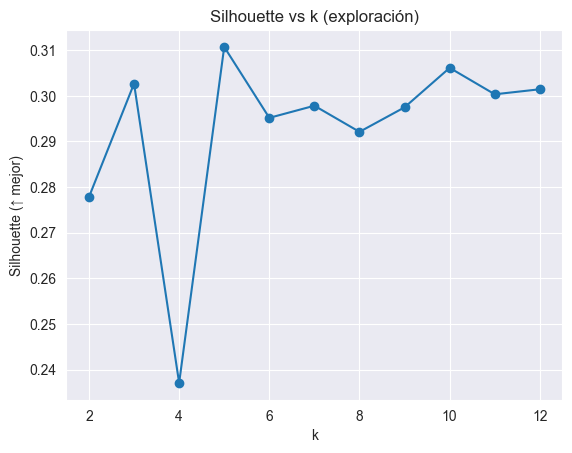

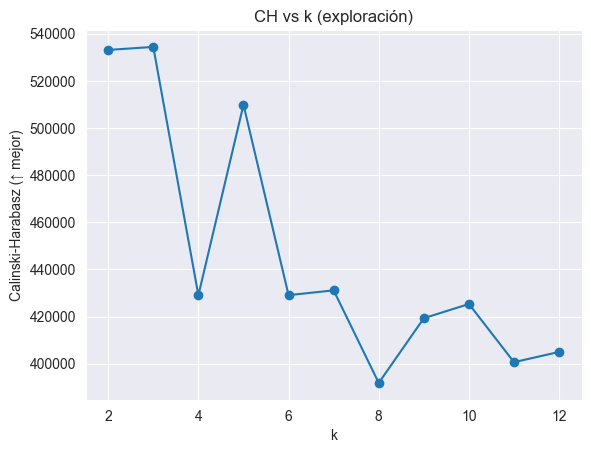

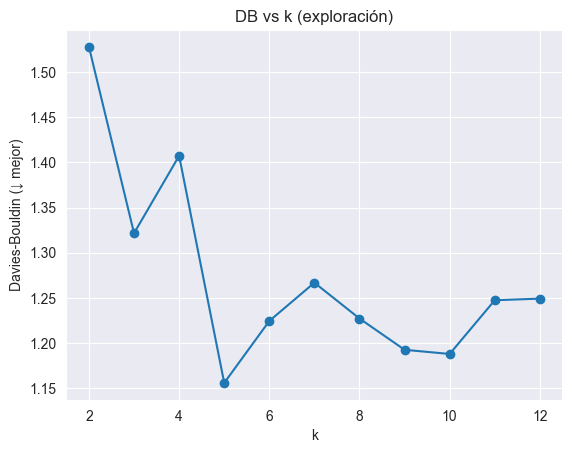

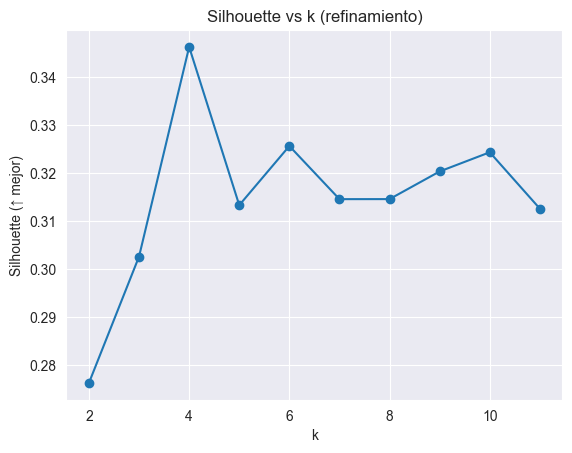

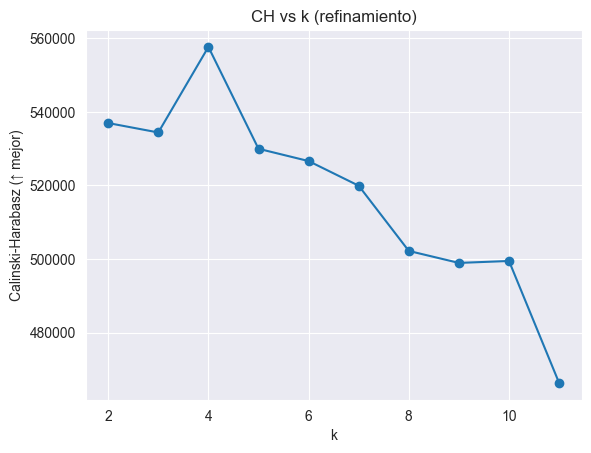

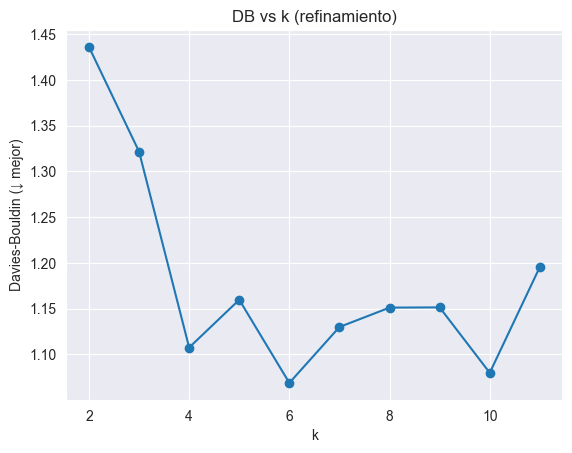

In [46]:

def plot_metrics(metrics_df, title_suffix=""):
    x = metrics_df["k"]
    plt.figure()
    plt.plot(x, metrics_df["silhouette"], marker="o")
    plt.xlabel("k"); plt.ylabel("Silhouette (↑ mejor)")
    plt.title(f"Silhouette vs k{title_suffix}"); plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(x, metrics_df["calinski_harabasz"], marker="o")
    plt.xlabel("k"); plt.ylabel("Calinski-Harabasz (↑ mejor)")
    plt.title(f"CH vs k{title_suffix}"); plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(x, metrics_df["davies_bouldin"], marker="o")
    plt.xlabel("k"); plt.ylabel("Davies-Bouldin (↓ mejor)")
    plt.title(f"DB vs k{title_suffix}"); plt.grid(True)
    plt.show()

plot_metrics(metrics_quick, " (exploración)")
plot_metrics(metrics_ref, " (refinamiento)")

In [47]:
def choose_k(metrics_df):
    m = metrics_df.copy()
    # Rank: mayor mejor para silhouette/CH; menor mejor para DB
    m["rank_sil"] = (-m["silhouette"]).rank(method="min")
    m["rank_ch"]  = (-m["calinski_harabasz"]).rank(method="min")
    m["rank_db"]  = (m["davies_bouldin"]).rank(method="min")
    # Pondera (ajusta si quieres). Doy más peso a silhouette y CH.
    m["score"] = 0.45*m["rank_sil"] + 0.45*m["rank_ch"] + 0.10*m["rank_db"]
    k_best = int(m.sort_values("score").iloc[0]["k"])
    return k_best, m.sort_values("score")[["k","score","rank_sil","rank_ch","rank_db"]]

k_auto, k_ranking = choose_k(metrics_ref)
print("Ranking de k (menor score = mejor):")
print(k_ranking.head(10))
print(f"\n→ k seleccionado automáticamente: {k_auto}")

Ranking de k (menor score = mejor):
    k  score  rank_sil  rank_ch  rank_db
2   4   1.20       1.0      1.0      3.0
4   6   3.25       2.0      5.0      1.0
8  10   5.15       3.0      8.0      2.0
3   5   5.65       7.0      4.0      7.0
5   7   5.80       6.0      6.0      4.0
6   8   5.90       5.0      7.0      5.0
1   3   6.30       9.0      3.0      9.0
0   2   6.40      10.0      2.0     10.0
7   9   6.45       4.0      9.0      6.0
9  11   8.90       8.0     10.0      8.0

→ k seleccionado automáticamente: 4


In [48]:
# 2) Entrenar modelo final (usa 'elkan', n_init moderado)
k_final = k_auto  # o fija manualmente: k_final = 4
km_final = KMeans(n_clusters=k_final, n_init=10, max_iter=300, random_state=42, algorithm="elkan", tol=1e-4)
km_final.fit(X)
labels_final = km_final.labels_


## Final model fit and metrics

Train final KMeans (k_final=4); compute Silhouette/CH/DB and save to data/kmeans_final_metrics.csv; persist centroids/inertia (*_final.joblib) and raw labels (k{k}_labels.npy). Append cluster_k to the balanced dataframe and export: data/db_balanced_with_clusters_k{k}.csv, data/Full_dataset_clustering.csv. Report cluster sizes and % composition by essence to interpret niche overlap vs. separation. Load shapefile (WGS84), subsample for performance, plot clusters by lon/lat, and overlay centroids mapped to nearest real points; export images/clusters_on_map.png.

In [49]:
n = X.shape[0]
sil_sample = min(10000, n)
try:
    sil_final = silhouette_score(X, labels_final, sample_size=sil_sample, random_state=42) if sil_sample < n else silhouette_score(X, labels_final)
except Exception:
    sil_final = np.nan
ch_final  = calinski_harabasz_score(X, labels_final)
db_final  = davies_bouldin_score(X, labels_final)

final_row = pd.DataFrame([{
    "k": k_final,
    "n_samples": n,
    "pca_components": X.shape[1],
    "silhouette": sil_final,
    "calinski_harabasz": ch_final,
    "davies_bouldin": db_final
}])
final_row.to_csv("data/kmeans_final_metrics.csv", index=False)

In [50]:
dump({"k": k_final,
      "cluster_centers_": km_final.cluster_centers_,
      "inertia_": km_final.inertia_},
     f"models_k_full/k{k_final}_final.joblib")

np.save(f"k{k_final}_labels.npy", labels_final)  # etiquetas crudas

In [51]:
# 5) Añadir etiquetas a tu dataframe y exportar
db_with_clusters = db_balanced.copy()
db_with_clusters["cluster_k"] = labels_final
db_with_clusters.to_csv(f"data/db_balanced_with_clusters_k{k_final}.csv", index=False)


In [52]:
# 6) Tablas rápidas: tamaño de clusters y composición por 'essence'
counts = db_with_clusters["cluster_k"].value_counts().sort_index()
print("\nTamaño por cluster:")
print(counts)

comp = (db_with_clusters.groupby("cluster_k")["essence"]
        .value_counts(normalize=True)
        .mul(100)
        .rename("pct")
        .reset_index()
        .pivot(index="cluster_k", columns="essence", values="pct")
        .fillna(0)
        .round(2))
print("\nComposición % por 'essence' en cada cluster:")
print(comp)
comp.to_csv(f"data/cluster_composition_by_essence_k{k_final}.csv")


Tamaño por cluster:
cluster_k
0    347788
1    472519
2    180283
3    412680
Name: count, dtype: int64

Composición % por 'essence' en cada cluster:
essence       EO     ES
cluster_k              
0          62.94  37.06
1          64.60  35.40
2          68.63  31.37
3          48.49  51.51


In [53]:
db_with_clusters.to_csv(f"data/Full_dataset_clustering.csv")

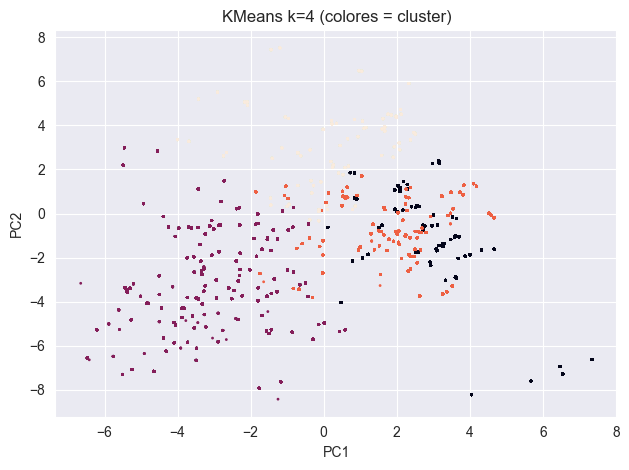

In [57]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=labels_final, s=1)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"KMeans k={k_final} (colores = cluster)")
plt.tight_layout()
plt.show()


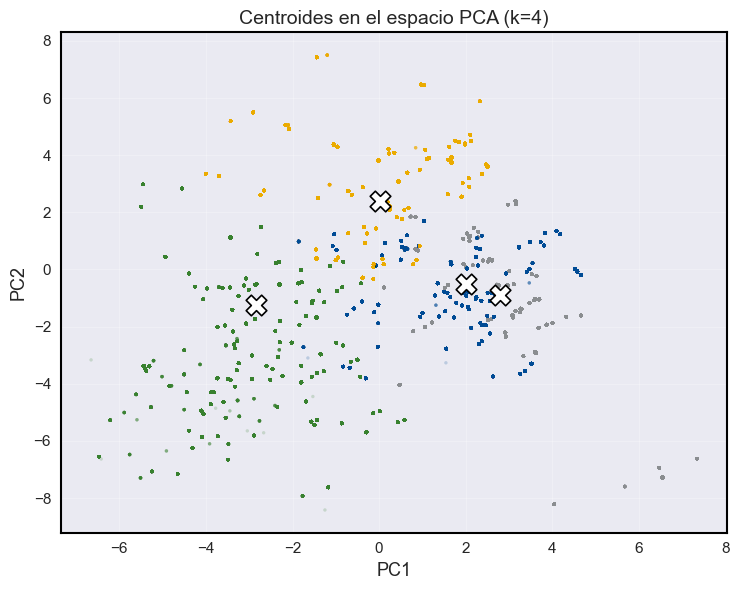

In [54]:
palette = {0: '#8A8D90', 1: '#38812F', 2: '#004B95', 3: '#F0AB00'}

# (opcional) marcadores por cluster
markers = {0: 'o', 1: 'o', 2: 'o', 3: 'o'}  # cambia a tu gusto

# estilos
point_size = 6
point_alpha = 0.20
centroid_color = 'black'
centroid_marker = 'X'
centroid_size = 160
centroid_edgecolor = 'black'
centroid_linewidth = 1.2
figsize = (7.5, 6.0)
axis_fs, tick_fs, title_fs, legend_fs = 13, 11, 14, 11

cent = km_final.cluster_centers_

plt.figure(figsize=figsize)

unique_clusters = sorted(np.unique(labels_final))
for cl in unique_clusters:
    m = (labels_final == cl)
    color  = palette.get(cl, '#999999')
    marker = markers.get(cl, 'o')
    plt.scatter(
        X[m, 0], X[m, 1],
        s=point_size,
        c=color,
        marker=marker,
        alpha=point_alpha,
        edgecolors='none',
        linewidths=0.0,
        label=f'Cluster {cl}',
        zorder=1
    )

# centroides
plt.scatter(
    cent[:, 0], cent[:, 1],
    s=220,
    c='white',
    marker='X',
    edgecolors='black',
    linewidths=1.2,
    label='Centroides',
    zorder=3
)

plt.xlabel("PC1", fontsize=axis_fs)
plt.ylabel("PC2", fontsize=axis_fs)
plt.title(f"Centroides en el espacio PCA (k={k_final})", fontsize=title_fs)
plt.xticks(fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)
plt.grid(True, alpha=0.25)

# === Bordes negros del gráfico ===
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('images/clusters_PCA.png', transparent=True, dpi=300)
plt.show()

In [55]:
from sklearn.metrics import pairwise_distances_argmin_min
import geopandas as gpd

In [56]:
shapefile_path = "data/Politic_divition/Total_quebec.shp"

# Tu paleta: mapea label -> color
palette = {0: '#8A8D90', 1: '#38812F', 2: '#004B95', 3: '#F0AB00'}


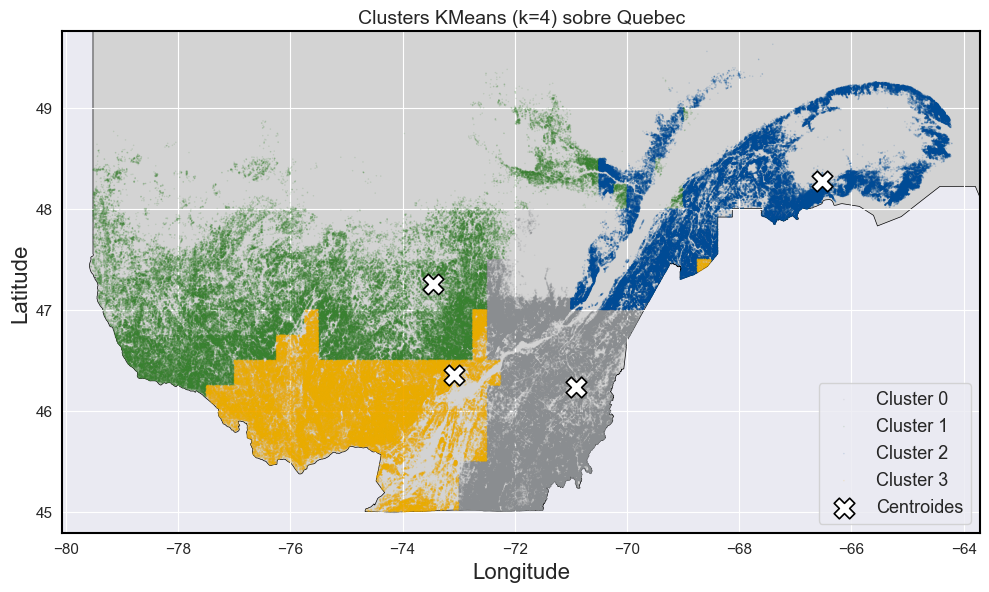

In [63]:
# plotting
figsize = (10, 15)
point_size = 1.2
point_alpha = 0.15
sample_per_cluster = 200_000   # None = sin muestreo; baja si va lento
centroid_size = 220
centroid_edgecolor = 'black'
centroid_marker = 'X'
centroid_linewidth = 1.2

axis_fs = 16
tick_fs = 11
title_fs = 14
# ============================================================

# --- 1) Cargar shapefile y asegurar CRS en WGS84
quebec_map = gpd.read_file(shapefile_path)
try:
    if quebec_map.crs is None:
        # si no trae CRS, asumimos WGS84 (ajústalo si no corresponde)
        quebec_map = quebec_map.set_crs(epsg=4326)
    else:
        quebec_map = quebec_map.to_crs(epsg=4326)
except Exception:
    # si falla, seguimos sin reproyectar
    pass

# --- 2) Asegurar columnas esperadas
required_cols = {'latitude','longitude','cluster_k'}
missing = required_cols - set(db_with_clusters.columns)
assert not missing, f"Faltan columnas en db_with_clusters: {missing}"

# --- 3) Obtén centroides geográficos como puntos reales más cercanos en PCA
#      (usa tus variables ya calculadas: X = data_pca y km_final)
centroids_pca = km_final.cluster_centers_
closest_points_idx, _ = pairwise_distances_argmin_min(centroids_pca, X, metric='euclidean')
centroid_coords = db_with_clusters.iloc[closest_points_idx][['longitude', 'latitude']].reset_index(drop=True)

# --- 4) Submuestreo opcional por cluster para acelerar el plot
labels = db_with_clusters['cluster_k'].to_numpy()
unique_clusters = np.sort(db_with_clusters['cluster_k'].unique())

if sample_per_cluster is not None:
    idx_keep = []
    rng = np.random.default_rng(42)
    for cl in unique_clusters:
        mask = (labels == cl)
        idx = np.flatnonzero(mask)
        if idx.size > sample_per_cluster:
            idx = rng.choice(idx, size=sample_per_cluster, replace=False)
        idx_keep.append(idx)
    idx_keep = np.concatenate(idx_keep)
else:
    idx_keep = np.arange(db_with_clusters.shape[0])

lon = db_with_clusters['longitude'].to_numpy()[idx_keep]
lat = db_with_clusters['latitude'].to_numpy()[idx_keep]
lab = labels[idx_keep]

# --- 5) Graficar
plt.figure(figsize=figsize)

# Mapa base
ax = plt.gca()
quebec_map.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5, zorder=0)

# Puntos por cluster (loop para colorear)
for i, cl in enumerate(unique_clusters):
    m = (lab == cl)
    if not np.any(m):
        continue
    clr = palette.get(int(cl), '#888888')  # fallback gris si falta el color
    plt.scatter(
        lon[m], lat[m],
        s=point_size,
        c=clr,
        alpha=point_alpha,
        edgecolors='none',
        linewidths=0.0,
        label=f'Cluster {cl}',
        zorder=1
    )

# Centroides (proyectados a coordenadas geo de los puntos más cercanos)
plt.scatter(
    centroid_coords['longitude'], centroid_coords['latitude'],
    s=centroid_size,
    c='white',                    # color de relleno del marcador
    marker=centroid_marker,
    edgecolors=centroid_edgecolor,
    linewidths=centroid_linewidth,
    label='Centroides',
    zorder=3
)

# Límites (zoom automático alrededor de los datos)
plt.xlim([db_with_clusters['longitude'].min() - 0.5,
          db_with_clusters['longitude'].max() + 0.5])
plt.ylim([db_with_clusters['latitude'].min() - 0.2,
          db_with_clusters['latitude'].max() + 0.10])

# Aspecto (alto/estirado)
plt.gca().set_aspect(1.8)

# Etiquetas y estilo
plt.title(f'Clusters KMeans (k={len(unique_clusters)}) sobre Quebec', fontsize=title_fs)
plt.xlabel('Longitude', fontsize=axis_fs)
plt.ylabel('Latitude', fontsize=axis_fs)
plt.xticks(fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

# Leyenda (si prefieres sin leyenda: comenta las dos líneas)
plt.legend(frameon=True, fontsize=13, loc='best')

# === Bordes negros del gráfico ===
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('images/clusters_on_mapd.png', transparent=True, dpi=300)
plt.show()

C:\Users\jorge\AppData\Local\Temp\ipykernel_29644\46680944.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('images/clusters_on_map_small.png', transparent=True, dpi=300)


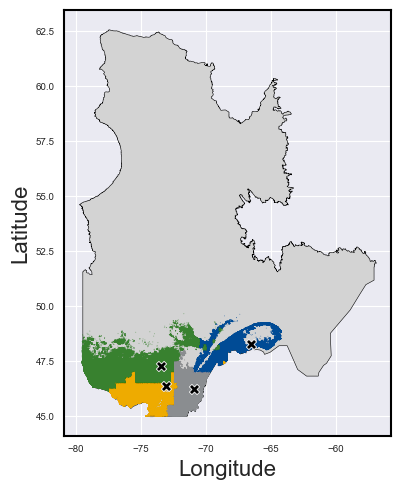

In [65]:
centroids_pca = km_final.cluster_centers_
closest_idx, _ = pairwise_distances_argmin_min(centroids_pca, X)  # X = data_pca
centroid_coords = db_with_clusters.iloc[closest_idx][['longitude', 'latitude']].reset_index(drop=True)

# 2) Figura pequeña
plt.figure(figsize=(5, 5))  # ajusta si quieres

# 3) Mapa base
ax = plt.gca()
quebec_map.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.4)

# 4) Puntos de cluster (muy pequeños y opacos para que se vean)
sns.scatterplot(
    x='longitude', y='latitude',
    hue='cluster_k', hue_order=sorted(db_with_clusters['cluster_k'].unique()),
    data=db_with_clusters,
    palette=palette,          # dict: {0:'#8A8D90', 1:'#38812F', 2:'#004B95', 3:'#F0AB00', ...}
    s=0.5, alpha=0.5, linewidth=0, edgecolor=None, ax=ax, legend=False
)

# 5) Centroides (coordenadas de los puntos reales más cercanos)
sns.scatterplot(
    x=centroid_coords['longitude'], y=centroid_coords['latitude'],
    color='black', s=55, marker='X', edgecolor='white', linewidth=0.6, ax=ax
)

# 6) Detalles
plt.title('', fontsize=8)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

# Sin leyenda
plt.legend([], [], frameon=False)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.savefig('images/clusters_on_map_small.png', transparent=True, dpi=300)
plt.show()

In [ ]:
db_balanced_2.to_csv('data/db_balanced_2.csv', index=False)

In [ ]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=numeric_columns)

# Display the loadings
print("PCA Loadings (Feature Contributions to Principal Components):")
print(loadings)

# Calculate the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_


In [ ]:
feature_importance = loadings.abs().sum(axis=1).sort_values(ascending=False)

# Display the most important features
print("Feature Importance based on PCA loadings:")
print(feature_importance.head(15))

In [ ]:
pd.set_option('display.max_columns', None)

factors = ['forest', 'elev', 'bio15', 'ph', 'bio7', 'bio3', 'bio31', 'sand', 'bio34', 'bio12', 'bio23', 'bio1']

# Agrupa los datos por 'Cluster' y calcula la media y desviación estándar para cada factor
cluster_stats = db_balanced.groupby('Cluster')[factors].agg(['mean', 'std'])

# Muestra los resultados
print(cluster_stats)

In [ ]:
dtype_spec2 = {
    'latitude': 'float64',
    'longitude': 'float64',
    'geocode': 'object',
    'essence': 'object',
    'RES_CO_REG': 'object'
}

# Ruta al archivo CSV
csv_file_path = 'data/data_final_with_regions.csv'
#csv_file_path = 'data_final_forestry_2.csv'


In [ ]:
rt = pd.read_csv(csv_file_path, dtype=dtype_spec2)

In [ ]:
db_balanced_2 = db_balanced.merge(rt[['latitude', 'longitude', 'essence', 'densite', 'superficie']], 
                                        on=['latitude', 'longitude', 'essence'], 
                                        how='left')

# Verify if 'densite' has been successfully added
print(db_balanced_2.head())

In [ ]:
del rt
gc.collect()

In [ ]:
density_stats_by_cluster_essence = db_balanced_2.groupby(['Cluster', 'essence'])['densite'].agg(['mean', 'std', 'min', 'max'])

# Display the result
print(density_stats_by_cluster_essence)

In [ ]:
db_balanced_2['occupied_area'] = (db_balanced_2['densite'] / 100) * db_balanced_2['superficie']

print(db_balanced_2[['essence', 'densite', 'superficie', 'occupied_area']].head())

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2x2 grid for 4 clusters
axes = axes.flatten()

# Define the clusters, ensuring they are sorted
clusters = sorted(db_balanced_2['Cluster'].unique())  # Sort clusters to ensure 0, 1, 2, 3 order
species = ['EO', 'ES']  # Modify if there are more species

# Define colors for EO (light red) and ES (light blue)
species_colors = {'EO': '#ca361c', 'ES': '#51a7dc'}

# Loop through each cluster to plot the histograms
for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Filter the data for the current cluster
    cluster_data = db_balanced_2[db_balanced_2['Cluster'] == cluster]
    
    # Plot the histogram for each species in this cluster
    for sp in species:
        sns.histplot(cluster_data[cluster_data['essence'] == sp]['occupied_area'], 
                     bins=30, alpha=0.5, label=sp, ax=ax, kde=True, color=species_colors[sp])
    
    # Set titles and labels
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('Occupied Area (hectares)')
    ax.set_ylabel('Frequency')
    ax.legend(title='Species')

# Adjust the layout for better spacing
plt.tight_layout()
plt.savefig('images/Histogram_hectare.png', transparent=True, dpi=300)

plt.show()

In [ ]:
# Filter for EO in the essence column
eo_data = db_balanced_2[db_balanced_2['essence'] == 'EO']

# Create the plot with a taller figure size
plt.figure(figsize=(10, 15))

# Plot the Quebec shapefile
quebec_map.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Plot the EO occurrences on top of the shapefile3
sns.scatterplot(x='longitude', y='latitude', data=eo_data, color='#ca361c', s=1, alpha=0.2)

# Set zoom by focusing on the data point ranges (adjust as necessary)
plt.xlim([eo_data['longitude'].min() - 0.5, eo_data['longitude'].max() + 0.5])
plt.ylim([eo_data['latitude'].min() - 0.2, eo_data['latitude'].max() + 0.10])

# Adjust aspect ratio to stretch the height
plt.gca().set_aspect(1.8)

# Set plot details
plt.title('Érable Rouge')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot as PNG with transparency
#plt.savefig('EO_occurrences_on_map.png', transparent=True, dpi=300)

# Display the plot
plt.show()

In [ ]:
# Filter for EO in the essence column
eo_data = db_balanced_2[db_balanced_2['essence'] == 'ES']

# Create the plot with a taller figure size
plt.figure(figsize=(10, 15))

# Plot the Quebec shapefile
quebec_map.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Plot the EO occurrences on top of the shapefile
sns.scatterplot(x='longitude', y='latitude', data=eo_data, color='#51a7dc', s=1, alpha=0.2)

# Set zoom by focusing on the data point ranges (adjust as necessary)
plt.xlim([eo_data['longitude'].min() - 0.5, eo_data['longitude'].max() + 0.5])
plt.ylim([eo_data['latitude'].min() - 0.2, eo_data['latitude'].max() + 0.10])

# Adjust aspect ratio to stretch the height
plt.gca().set_aspect(1.8)

# Set plot details
plt.title('Érable à Sucre')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot as PNG with transparency
#plt.savefig('EO_occurrences_on_map.png', transparent=True, dpi=300)

# Display the plot
plt.show()

In [ ]:
# Filter for EO and ES in the essence column
eo_data = db_balanced_2[db_balanced_2['essence'] == 'EO']  # Érable Rouge
es_data = db_balanced_2[db_balanced_2['essence'] == 'ES']  # Érable à Sucre

# Create the plot with a taller figure size
plt.figure(figsize=(10, 15))

# Plot the Quebec shapefile
quebec_map.plot(ax=plt.gca(), color='lightgray', edgecolor='black')

# Plot the EO occurrences (Érable Rouge) on top of the shapefile
sns.scatterplot(x='longitude', y='latitude', data=eo_data, color='#ca361c', s=1, alpha=0.03, label='Érable Rouge')

# Plot the ES occurrences (Érable à Sucre) on top of the shapefile
sns.scatterplot(x='longitude', y='latitude', data=es_data, color='#51a7dc', s=1, alpha=0.03, label='Érable à Sucre')

# Set zoom by focusing on the data point ranges (adjust as necessary)
plt.xlim([min(eo_data['longitude'].min(), es_data['longitude'].min()) - 0.5,
          max(eo_data['longitude'].max(), es_data['longitude'].max()) + 0.5])
plt.ylim([min(eo_data['latitude'].min(), es_data['latitude'].min()) - 0.2,
          max(eo_data['latitude'].max(), es_data['latitude'].max()) + 0.10])

# Adjust aspect ratio to stretch the height
plt.gca().set_aspect(1.8)

# Set plot details
plt.title('')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the legend
plt.legend([], [], frameon=False)
# Save the plot as PNG with transparency
plt.savefig('images/EO_ES_occurrences_on_map.png', transparent=True, dpi=300)

# Display the plot
plt.show()

In [ ]:
#pip install pointpats

In [ ]:

from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

In [ ]:


# Función para calcular la Función K de Ripley
def ripley_k(coords, max_radius, num_simulations=99, area=1):
    """Calcular la función K de Ripley para un conjunto de puntos."""
    n = len(coords)
    r_values = np.linspace(0, max_radius, 100)  # Radios
    K_values = np.zeros_like(r_values)

    # Matriz de distancias entre los puntos
    d_matrix = distance_matrix(coords, coords)

    # Contar puntos dentro de cada radio para cada punto
    for i, r in enumerate(r_values):
        K_values[i] = np.sum(d_matrix < r) / n

    # Normalizar por el área
    K_values /= (n / area)
    return r_values, K_values

# Función para muestrear puntos aleatorios
def sample_points(coords, sample_size=100000):
    if len(coords) > sample_size:
        return coords[np.random.choice(len(coords), size=sample_size, replace=False)]
    return coords

# Función para calcular la función K de Ripley por cluster
def ripley_k_by_cluster(cluster_data, cluster_label, max_radius=5, sample_size=20000):
    # Filtrar los datos de EO y ES por cluster
    eo_cluster_data = cluster_data[cluster_data['essence'] == 'EO'].copy()
    es_cluster_data = cluster_data[cluster_data['essence'] == 'ES'].copy()
    
    # Crear geometrías de puntos
    eo_cluster_data['geometry'] = gpd.points_from_xy(eo_cluster_data['longitude'], eo_cluster_data['latitude'])
    es_cluster_data['geometry'] = gpd.points_from_xy(es_cluster_data['longitude'], es_cluster_data['latitude'])
    
    # Crear listas de coordenadas para EO y ES
    eo_coords = np.array(list(eo_cluster_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
    es_coords = np.array(list(es_cluster_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
    
    # Muestrear puntos aleatorios si hay muchos puntos
    eo_coords = sample_points(eo_coords, sample_size)
    es_coords = sample_points(es_coords, sample_size)
    
    # Calcular el área de la región (aproximadamente)
    minx, miny, maxx, maxy = cluster_data['longitude'].min(), cluster_data['latitude'].min(), \
                             cluster_data['longitude'].max(), cluster_data['latitude'].max()
    area = (maxx - minx) * (maxy - miny)
    
    # Calcular la función K de Ripley para EO y ES
    eo_r, eo_k = ripley_k(eo_coords, max_radius, area=area)
    es_r, es_k = ripley_k(es_coords, max_radius, area=area)
    
    # Graficar los resultados para la comparación en el cluster
    plt.figure(figsize=(5, 3))
    plt.plot(eo_r, eo_k, label=f"EO (Érable Rouge) {cluster_label}", color='#ca361c')
    plt.plot(es_r, es_k, label=f"ES (Érable à Sucre) {cluster_label}", color='#51a7dc')
    plt.title(f"Cluster {cluster_label}")
    plt.xlabel('Distancia')
    plt.ylabel('Ripley’s K function')
    plt.legend()
    plt.grid(True)
    
    # Guardar la imagen en PNG con fondo transparente
    plt.savefig(f'images/ripley_k_cluster_{cluster_label}.png', transparent=True, dpi=300)

    # Mostrar el gráfico
    plt.show()


# Ejecutar el análisis por cluster
clusters = db_balanced_2['Cluster'].unique()

for cluster in clusters:
    cluster_data = db_balanced_2[db_balanced_2['Cluster'] == cluster]
    ripley_k_by_cluster(cluster_data, cluster)

In [ ]:
def plot_points_with_density_comparison(cluster_data, title, cluster_label):
    plt.figure(figsize=(6, 9))
    
    # Filtrar datos para EO (Érable Rouge) y ES (Érable à Sucre)
    eo_data = cluster_data[cluster_data['essence'] == 'EO']  # Érable Rouge
    es_data = cluster_data[cluster_data['essence'] == 'ES']  # Érable à Sucre
    
    # Plot EO (Érable Rouge) con baja opacidad
    sns.scatterplot(x='longitude', y='latitude', data=eo_data, color='#ca361c', alpha=0.05, s=2, label='Érable Rouge')
    
    # Plot ES (Érable à Sucre) con baja opacidad
    sns.scatterplot(x='longitude', y='latitude', data=es_data, color='#51a7dc', alpha=0.05, s=2, label='Érable à Sucre')
    
    # Configuración del gráfico
    plt.title("")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend([], [], frameon=False)
    
    # Guardar la figura como PNG con fondo transparente
    plt.savefig(f'images/points_density_cluster_{cluster_label}.png', transparent=True, dpi=300, bbox_inches='tight')

    plt.show()

# Ejecutar para cada cluster y guardar el gráfico
for cluster in clusters:
    cluster_data = db_balanced_2[db_balanced_2['Cluster'] == cluster]
    plot_points_with_density_comparison(cluster_data, f"Distribución de Puntos para Cluster {cluster}", cluster)
    

In [ ]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import numpy as np

# Función para calcular la Función K de Ripley
def ripley_k(coords, max_radius, area=1):
    """Calcular la función K de Ripley para un conjunto de puntos."""
    n = len(coords)
    r_values = np.linspace(0, max_radius, 100)  # Radios
    K_values = np.zeros_like(r_values)

    # Matriz de distancias entre los puntos
    d_matrix = distance_matrix(coords, coords)

    # Contar puntos dentro de cada radio para cada punto
    for i, r in enumerate(r_values):
        K_values[i] = np.sum(d_matrix < r) / n

    # Normalizar por el área
    K_values /= (n / area)
    return r_values, K_values

# Función para calcular L(t) a partir de K(t)
def ripley_l(K_values):
    """Calcular la función L(t) de Ripley a partir de la función K(t)."""
    return np.sqrt(K_values / np.pi)

# Función para muestrear puntos aleatorios
def sample_points(coords, sample_size=100000):
    if len(coords) > sample_size:
        return coords[np.random.choice(len(coords), size=sample_size, replace=False)]
    return coords

# Función para calcular la función L(t) de Ripley por cluster
def ripley_l_by_cluster(cluster_data, cluster_label, max_radius=5, sample_size=20000):
    # Filtrar los datos de EO y ES por cluster
    eo_cluster_data = cluster_data[cluster_data['essence'] == 'EO'].copy()
    es_cluster_data = cluster_data[cluster_data['essence'] == 'ES'].copy()
    
    # Crear geometrías de puntos
    eo_cluster_data['geometry'] = gpd.points_from_xy(eo_cluster_data['longitude'], eo_cluster_data['latitude'])
    es_cluster_data['geometry'] = gpd.points_from_xy(es_cluster_data['longitude'], es_cluster_data['latitude'])
    
    # Crear listas de coordenadas para EO y ES
    eo_coords = np.array(list(eo_cluster_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
    es_coords = np.array(list(es_cluster_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
    
    # Muestrear puntos aleatorios si hay muchos puntos
    eo_coords = sample_points(eo_coords, sample_size)
    es_coords = sample_points(es_coords, sample_size)
    
    # Calcular el área de la región (aproximadamente)
    minx, miny, maxx, maxy = cluster_data['longitude'].min(), cluster_data['latitude'].min(), \
                             cluster_data['longitude'].max(), cluster_data['latitude'].max()
    area = (maxx - minx) * (maxy - miny)
    
    # Calcular la función K de Ripley para EO y ES
    eo_r, eo_k = ripley_k(eo_coords, max_radius, area=area)
    es_r, es_k = ripley_k(es_coords, max_radius, area=area)
    
    # Calcular la función L(t) de Ripley
    eo_l = ripley_l(eo_k)
    es_l = ripley_l(es_k)
    
    # Graficar los resultados para la comparación en el cluster
    plt.figure(figsize=(5, 3))
    
    # Graficar EO (Érable Rouge)
    plt.plot(eo_r, eo_l, label=f"EO (Red Maple) - Cluster {cluster_label}", color='#ca361c')
    
    # Graficar ES (Érable à Sucre)
    plt.plot(es_r, es_l, label=f"ES (Sugar Maple) - Cluster {cluster_label}", color='#51a7dc')
    
    # Línea teórica L(t) = t
    plt.plot(eo_r, eo_r, label='L(t) = t (Random)', color='black', linestyle='--')
    
    plt.title(f"Cluster {cluster_label}")
    plt.xlabel('Distance')
    plt.ylabel("L(t)")
    plt.legend()
    plt.grid(True)
    
    # Guardar la imagen en PNG con fondo transparente
    #plt.savefig(f'ripley_l_cluster_{cluster_label}.png', transparent=True, dpi=300)

    # Mostrar el gráfico
    plt.show()

# Ejecutar el análisis por cluster
clusters = db_balanced_2['Cluster'].unique()

for cluster in clusters:
    cluster_data = db_balanced_2[db_balanced_2['Cluster'] == cluster]
    ripley_l_by_cluster(cluster_data, cluster)

In [ ]:
import geopandas as gpd

# Crear un GeoDataFrame de los datos
gdf = gpd.GeoDataFrame(db_balanced_2, geometry=gpd.points_from_xy(db_balanced_2['longitude'], db_balanced_2['latitude']))

# Proyectar a UTM (distancia métrica)
gdf = gdf.set_crs(epsg=4326)  # WGS 84 (lat/lon)
gdf = gdf.to_crs(epsg=32618)  # Cambia esto según la zona UTM adecuada para tu región (Quebec está entre 32618-32619)

# Coordenadas proyectadas a metros
print(gdf[['geometry']].head()) 

In [ ]:
#pip install esda

In [ ]:
# Función para calcular la Función K de Ripley
def ripley_k(coords, max_radius, area=1):
    """Calcular la función K de Ripley para un conjunto de puntos."""
    n = len(coords)
    r_values = np.linspace(0, max_radius, 100)  # Radios en metros
    K_values = np.zeros_like(r_values)

    # Matriz de distancias entre los puntos
    d_matrix = distance_matrix(coords, coords)

    # Contar puntos dentro de cada radio para cada punto
    for i, r in enumerate(r_values):
        K_values[i] = np.sum(d_matrix < r) / n

    # Normalizar por el área
    K_values /= (n / area)
    return r_values, K_values

# Función para calcular L(t) a partir de K(t)
def ripley_l(K_values):
    """Calcular la función L(t) de Ripley a partir de la función K(t)."""
    return np.sqrt(K_values / np.pi)

# Función para muestrear puntos aleatorios si es necesario
def sample_points(coords, sample_size=100000):
    if len(coords) > sample_size:
        return coords[np.random.choice(len(coords), size=sample_size, replace=False)]
    return coords

# Función para calcular la función L(t) de Ripley por cluster
def ripley_l_by_cluster(cluster_data, cluster_label, max_radius=400000, sample_size=20000):
    # Filtrar los datos de EO y ES por cluster
    eo_cluster_data = cluster_data[cluster_data['essence'] == 'EO'].copy()
    es_cluster_data = cluster_data[cluster_data['essence'] == 'ES'].copy()
    
    # Obtener las coordenadas proyectadas (en metros, UTM)
    eo_coords = np.array(list(eo_cluster_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
    es_coords = np.array(list(es_cluster_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
    
    # Muestrear puntos aleatorios si hay muchos puntos
    eo_coords = sample_points(eo_coords, sample_size)
    es_coords = sample_points(es_coords, sample_size)
    
    # Calcular el área de la región (aproximadamente)
    minx, miny, maxx, maxy = cluster_data['geometry'].total_bounds
    area = (maxx - minx) * (maxy - miny)
    
    # Calcular la función K de Ripley para EO y ES
    eo_r, eo_k = ripley_k(eo_coords, max_radius, area=area)
    es_r, es_k = ripley_k(es_coords, max_radius, area=area)
    
    # Calcular la función L(t) de Ripley
    eo_l = ripley_l(eo_k)
    es_l = ripley_l(es_k)
    
    # Graficar los resultados para la comparación en el cluster
    plt.figure(figsize=(5, 6))
    
    # Convertir distancias de metros a kilómetros (para el eje x)
    eo_r_km = eo_r / 1000
    es_r_km = es_r / 1000
    
    # Graficar EO (Érable Rouge)
    plt.plot(eo_r_km, eo_l, label=f"EO (Red Maple)", color='#ca361c')
    
    # Graficar ES (Érable à Sucre)
    plt.plot(es_r_km, es_l, label=f"ES (Sugar Maple)", color='#51a7dc')
    
    # Línea teórica L(t) = t
    plt.plot(eo_r_km, eo_r, label='L(t) = t (Random)', color='black', linestyle='--')
    
    plt.title("")
    plt.xlabel('Distance (km)')
    plt.ylabel("L(t)")
    plt.legend()
    plt.grid(True)
    
    # Guardar la imagen en PNG con fondo transparente
    plt.savefig(f'images/ripley_l_cluster_{cluster_label}.png', transparent=True, dpi=300, bbox_inches='tight')

    # Mostrar el gráfico
    plt.show()

# Crear un GeoDataFrame proyectado
gdf = gpd.GeoDataFrame(db_balanced_2, geometry=gpd.points_from_xy(db_balanced_2['longitude'], db_balanced_2['latitude']))

# Proyectar a UTM (distancia métrica)
gdf = gdf.set_crs(epsg=4326)  # WGS 84 (lat/lon)
gdf = gdf.to_crs(epsg=32618)  # UTM Zona adecuada (Quebec está en 18 o 19)

# Ejecutar el análisis por cluster con los datos proyectados
clusters = gdf['Cluster'].unique()

for cluster in clusters:
    cluster_data = gdf[gdf['Cluster'] == cluster]
    ripley_l_by_cluster(cluster_data, cluster)

In [ ]:
# Función para calcular la Función K de Ripley
def ripley_k(coords, max_radius, area=1):
    """Calcular la función K de Ripley para un conjunto de puntos."""
    n = len(coords)
    r_values = np.linspace(0, max_radius, 100)  # Radios en metros
    K_values = np.zeros_like(r_values)

    # Matriz de distancias entre los puntos
    d_matrix = distance_matrix(coords, coords)

    # Contar puntos dentro de cada radio para cada punto
    for i, r in enumerate(r_values):
        K_values[i] = np.sum(d_matrix < r) / n

    # Normalizar por el área
    K_values /= (n / area)
    return r_values, K_values

# Función para calcular L(t) a partir de K(t)
def ripley_l(K_values):
    """Calcular la función L(t) de Ripley a partir de la función K(t)."""
    return np.sqrt(K_values / np.pi)

# Función para muestrear puntos aleatorios si es necesario
def sample_points(coords, sample_size=100000):
    if len(coords) > sample_size:
        return coords[np.random.choice(len(coords), size=sample_size, replace=False)]
    return coords

# Función para calcular la función L(t) de Ripley por cluster
def ripley_l_by_cluster(cluster_data, cluster_label, max_radius=400000, sample_size=20000):
    # Filtrar los datos de EO y ES por cluster
    eo_cluster_data = cluster_data[cluster_data['essence'] == 'EO'].copy()
    es_cluster_data = cluster_data[cluster_data['essence'] == 'ES'].copy()

    # Obtener las coordenadas proyectadas (en metros, UTM)
    eo_coords = np.array(list(eo_cluster_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
    es_coords = np.array(list(es_cluster_data['geometry'].apply(lambda geom: (geom.x, geom.y))))

    # Muestrear puntos aleatorios si hay muchos puntos
    eo_coords = sample_points(eo_coords, sample_size)
    es_coords = sample_points(es_coords, sample_size)

    # Calcular el área de la región (aproximadamente)
    minx, miny, maxx, maxy = cluster_data['geometry'].total_bounds
    area = (maxx - minx) * (maxy - miny)

    # Calcular la función K de Ripley para EO y ES
    eo_r, eo_k = ripley_k(eo_coords, max_radius, area=area)
    es_r, es_k = ripley_k(es_coords, max_radius, area=area)

    # Calcular la función L(t) de Ripley
    eo_l = ripley_l(eo_k)
    es_l = ripley_l(es_k)

    # Graficar los resultados para la comparación en el cluster
    plt.figure(figsize=(5, 3))

    # Convertir distancias de metros a kilómetros (para el eje x)
    eo_r_km = eo_r / 1000
    es_r_km = es_r / 1000

    # Graficar EO (Érable Rouge)
    plt.plot(eo_r_km, eo_l, label=f"EO (Red Maple)", color='#ca361c')

    # Graficar ES (Érable à Sucre)
    plt.plot(es_r_km, es_l, label=f"ES (Sugar Maple)", color='#51a7dc')

    # Línea teórica L(t) = t
    plt.plot(eo_r_km, eo_r, label='L(t) = t (Random)', color='black', linestyle='--')

    plt.title(f"Cluster {cluster_label}")
    plt.xlabel('Distance (km)')
    plt.ylabel("L(t)")
    plt.legend()
    plt.grid(True)

    # Mostrar el gráfico
    plt.show()

# Crear un GeoDataFrame proyectado
gdf = gpd.GeoDataFrame(db_balanced_2, geometry=gpd.points_from_xy(db_balanced_2['longitude'], db_balanced_2['latitude']))

# Proyectar a UTM (distancia métrica)
gdf = gdf.set_crs(epsg=4326)  # WGS 84 (lat/lon)
gdf = gdf.to_crs(epsg=32618)  # UTM Zona adecuada (Quebec está en 18 o 19)

# Ejecutar el análisis por cluster con los datos proyectados
clusters = gdf['Cluster'].unique()

for cluster in clusters:
    cluster_data = gdf[gdf['Cluster'] == cluster]
    ripley_l_by_cluster(cluster_data, cluster)

In [ ]:
db_balanced_2.to_csv('data/db_balanced_2.csv', index=False)